In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")
from sklearn.decomposition import PCA
import time

In [2]:
class Model:
    
    def __init__(self, learning_rate, num_layers, shape_3d, size_layer):

        self.num_layers = num_layers
        self.size_layer = size_layer
        
        rnn_cells = tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        self.rnn_cells =  tf.nn.rnn_cell.MultiRNNCell([rnn_cells] * num_layers, state_is_tuple = False)
        
        self.X = tf.placeholder(tf.float32, (None, None, shape_3d))
        self.Y = tf.placeholder(tf.float32, (None, None, shape_3d))
        
        self.net_last_state = np.zeros((num_layers * 2 * size_layer))
        
        self.hidden_layer = tf.placeholder(tf.float32, shape=(None, num_layers * 2 * size_layer))
        
        self.outputs, self.last_state = tf.nn.dynamic_rnn(self.rnn_cells, self.X, initial_state = self.hidden_layer, dtype = tf.float32)
        
        self.rnn_W = tf.Variable(tf.random_normal((size_layer, shape_3d)))
        self.rnn_B = tf.Variable(tf.random_normal((shape_3d,)))
            
        # linear dimension for x in (Wx + B)
        outputs_reshaped = tf.reshape(self.outputs, [-1, size_layer])
        
        y_batch_long = tf.reshape(self.Y, [-1, shape_3d])

        # y = Wx + B
        self.logits = (tf.matmul(outputs_reshaped, self.rnn_W) + self.rnn_B)
        
        self.cost = tf.square(y_batch_long - self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

    def step(self, sess, x, init_zero_state = True):

        # Reset the initial state of the network.
        if init_zero_state:
            init_value = np.zeros((self.num_layers * 2 * self.size_layer,))
        else:
            init_value = self.net_last_state
        
        # we want to get the constant in our output layer, same size as dimension input
        probs, next_lstm_state = sess.run([self.logits, self.last_state], feed_dict={self.X:[x], self.hidden_layer:[init_value]})

        self.net_last_state = next_lstm_state[0]

        return probs

In [3]:
dataset = pd.read_csv('/home/huseinzol05/Downloads/MyCertAllYearStat.csv')

dataset = dataset.ix[:, 1:] / 1000

dataset = dataset.fillna(value = 0)

dataset = np.fliplr(dataset.ix[:, :].values)

In [4]:
num_layers = 2
size_layer = 128

learning_rate = 0.01

epoch = 100

# this is for neural network
model = Model(learning_rate, num_layers, 1, size_layer)

# start the session graph
sess = tf.InteractiveSession()
    
# initialize global variables
sess.run(tf.global_variables_initializer())

In [5]:
print "Train for " + str(epoch) + " iteration"

for i in xrange(epoch):
    last_time = time.time()
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    
    for x in xrange(dataset.shape[1] - 1):
        _, loss = sess.run([model.optimizer, model.cost], feed_dict={model.X: np.array([dataset[:, x: x + 1]]), 
                                                                    model.Y: np.array([dataset[: , x + 1: x + 2]]), 
                                                                    model.hidden_layer: init_value})

    diff = time.time() - last_time
    print "batch: " + str(i + 1) + ", loss: " + str(np.mean(loss)) + ", speed: " + str(diff) + " s / epoch"


Train for 100 iteration
batch: 1, loss: 0.6816, speed: 0.512943983078 s / epoch
batch: 2, loss: 0.527493, speed: 0.283687114716 s / epoch
batch: 3, loss: 0.467889, speed: 0.286144971848 s / epoch
batch: 4, loss: 0.310593, speed: 0.279654979706 s / epoch
batch: 5, loss: 0.263025, speed: 0.281625032425 s / epoch
batch: 6, loss: 0.499645, speed: 0.278165817261 s / epoch
batch: 7, loss: 0.356735, speed: 0.288713932037 s / epoch
batch: 8, loss: 0.293521, speed: 0.283304929733 s / epoch
batch: 9, loss: 0.321575, speed: 0.286134004593 s / epoch
batch: 10, loss: 0.864051, speed: 0.287437915802 s / epoch
batch: 11, loss: 0.298009, speed: 0.309641122818 s / epoch
batch: 12, loss: 0.43093, speed: 0.279893875122 s / epoch
batch: 13, loss: 0.50823, speed: 0.282752037048 s / epoch
batch: 14, loss: 0.293704, speed: 0.398171186447 s / epoch
batch: 15, loss: 0.335422, speed: 0.27992606163 s / epoch
batch: 16, loss: 0.321704, speed: 0.282063007355 s / epoch
batch: 17, loss: 0.564918, speed: 0.2846112251

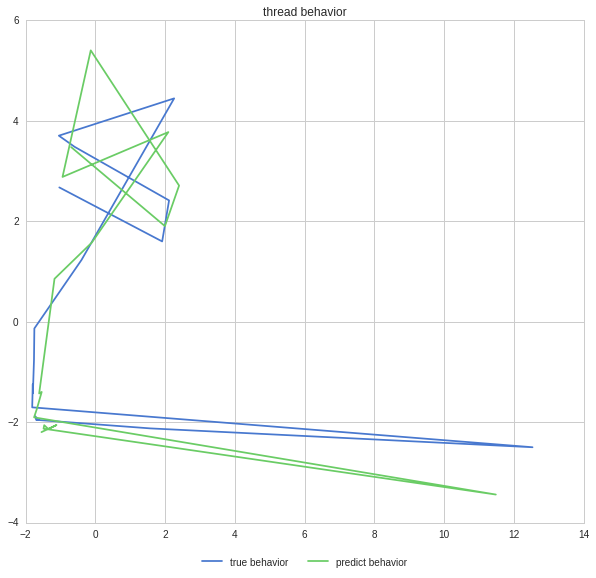

In [6]:
data = []
data.append(dataset[:, 0].T)
probs = model.step(sess, np.array([dataset[:, 0]]).T, True)
data.append(probs[:, 0].tolist())

for x in xrange(1, dataset.shape[1] - 1, 1):
    probs = model.step(sess, np.array([dataset[:, x]]).T, False)
    data.append(probs[:, 0].tolist())

fig = plt.figure(figsize = (10,10))

ax = plt.subplot(111)

dataset = dataset.T

x_true = PCA(n_components = 2).fit_transform(dataset)
x_predict = PCA(n_components = 2).fit_transform(np.array(data))

ax.plot(x_true[:, 0], x_true[:, 1], label = 'true behavior')
ax.plot(x_predict[:, 0], x_predict[:, 1], label = 'predict behavior')
    
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)

plt.title('thread behavior')
plt.show()